In [2]:
!pip install transformers

In [3]:
!pip uninstall -y transformers accelerate
!pip install transformers accelerate

Found existing installation: transformers 4.33.0
Uninstalling transformers-4.33.0:
  Successfully uninstalled transformers-4.33.0
Found existing installation: accelerate 0.22.0
Uninstalling accelerate-0.22.0:
  Successfully uninstalled accelerate-0.22.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 22.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.1/346.1 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 68.4 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.7 MB/s eta 0:00:00
  Attempting uninstall: safetensors
    Found existing installation: safetensors 0.3.3
    Uninstalling safetensors-0.3.3:
      Successfully uninstalled safetensors-0.3.3
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.16.4
    Uninstalling huggingface-hub-0.16.4:
      Successfully uni

In [4]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForPreTraining,AutoModel

from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
from transformers import Trainer, TrainingArguments
from IPython.display import clear_output

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

!pip install pymorphy2
import re
from pymorphy2 import MorphAnalyzer
from functools import lru_cache
from nltk.corpus import stopwords
from sklearn.feature_selection import SelectKBest,SelectPercentile,f_classif
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split as tts
import scikitplot as skplt

from multiprocessing import Pool
from tqdm import tqdm

import nltk
nltk.download('stopwords')

np.random.seed(42)
random.seed(42)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.0 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 24.8 MB/s eta 0:00:0000:0100:01
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# EDA

In [8]:
data = pd.read_json('/kaggle/input/work-2/subtaskA_train_monolingual.jsonl', lines=True)
data

,text,label,model,source,id
0,Forza Motorsport is a popular racing game that...,1,chatGPT,wikihow,0
1,Buying Virtual Console games for your Nintendo...,1,chatGPT,wikihow,1
2,Windows NT 4.0 was a popular operating system ...,1,chatGPT,wikihow,2
3,How to Make Perfume\n\nPerfume is a great way ...,1,chatGPT,wikihow,3
4,How to Convert Song Lyrics to a Song'\n\nConve...,1,chatGPT,wikihow,4
...,...,...,...,...,...
119752,"The paper is an interesting contribution, prim...",0,human,peerread,119752
119753,\nWe thank the reviewers for all their comment...,0,human,peerread,119753
119754,The authors introduce a semi-supervised method...,0,human,peerread,119754
119755,This paper proposes the Neural Graph Machine t...,0,human,peerread,119755


In [9]:
data['text'].str.len().mean()

2786.013519042728

In [10]:
2786*25

69650

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119757 entries, 0 to 119756
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    119757 non-null  object
 1   label   119757 non-null  int64 
 2   model   119757 non-null  object
 3   source  119757 non-null  object
 4   id      119757 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 4.6+ MB


Удаление NaN

In [12]:
data = data.dropna()

Взглянем на распределение по классам на всех данных

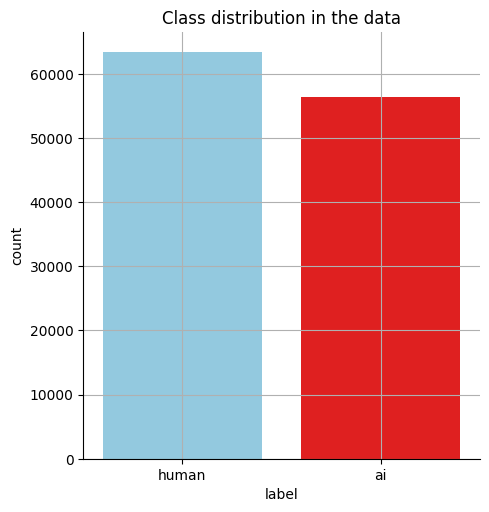

In [13]:
g = sns.catplot(x='label',
                kind="count",
                data=data.sort_values("label")[::-1],
                palette=sns.color_palette(['skyblue',"red"]))
plt.xticks([0, 1],['human', 'ai'])
plt.grid()
plt.title("Class distribution in the data");

## Лемматизация

In [14]:
m = MorphAnalyzer()
regex = re.compile("[A-z]+")
mystopwords = stopwords.words('english')

def words_only(text, regex=regex):
    try:
        return regex.findall(text.lower())
    except:
        return []

@lru_cache(maxsize=128)
def lemmatize_word(token, pymorphy=m):
    return pymorphy.parse(token)[0].normal_form

def lemmatize_text(text):
    return [lemmatize_word(w) for w in text]

def remove_stopwords(lemmas, stopwords = mystopwords):
    return [w for w in lemmas if not w in stopwords and len(w) > 3]

def clean_text(text):
    tokens = words_only(text)
    lemmas = lemmatize_text(tokens)

    return ' '.join(remove_stopwords(lemmas))

In [15]:
from multiprocessing import Pool as PoolSklearn
#train
with PoolSklearn(4) as p:
    lemmas = list(tqdm(p.imap(clean_text, data['text']), total=len(data)))

data['text_lemmas'] = lemmas

100%|██████████| 119757/119757 [06:18<00:00, 316.13it/s]


## Визуализация

In [ ]:
from wordcloud import WordCloud, STOPWORDS
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 500 , width = 1600 , height = 800 , stopwords = STOPWORDS)
wc.generate(' '.join(data.sample(n=5000)['text_lemmas']))
plt.imshow(wc , interpolation = 'bilinear')

In [ ]:
data['sym_len'] = data.text_lemmas.apply(len)
data['word_len'] = data.text_lemmas.apply(lambda x: len(x.split()))
data = data[data.sym_len > 0]
sns.distplot(data["sym_len"] , color="skyblue", label="Symdol Length");

In [ ]:
sns.distplot(data['word_len'] , color="red", label="Word Length");

Види и там и там распределения с длинными хвостами, чтобы исправить этого возбмем логорифм

In [ ]:
data['sym_len'] = np.log(data['sym_len'])
data['word_len'] = np.log(data['word_len'])

In [ ]:
sns.distplot(data['word_len'] , color="red", label="Word Length");

In [ ]:
sns.distplot(data["sym_len"] , color="skyblue", label="Symdol Length");

# Tf-Idf

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
vec = TfidfVectorizer(ngram_range=(1, 3),max_features = 5000)
data_vec = vec.fit_transform(data['text_lemmas'])

In [ ]:
from sklearn.decomposition import TruncatedSVD

pca = TruncatedSVD(n_components=3)
pca.fit(data_vec)

data_2 = pca.transform(data_vec)
df = pd.DataFrame(dict(x=data_2[:,0], y=data_2[:,1], z = data_2[:,2],label=data['label'].tolist()))
groups = df.groupby('label',sort=False)

cluster_colors = {0: 'skyblue',1:  'red'}
cluster_names = {0: 'hu', 1: 'ai'}

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection = '3d')
for name, group in groups:
    ax.scatter(group.x, group.y, group.z, marker='o', linestyle='', label=cluster_names[name], color=cluster_colors[name])
    ax.set_aspect('auto')
    ax.tick_params(
        axis= 'x',
        which='both',
        bottom='off',
        top='off',
        labelbottom='off')
    ax.tick_params(
        axis= 'y',
        which='both',
        left='off',
        top='off',
        labelleft='off')
ax.view_init(elev=30, azim=25)
plt.grid(which='both')
plt.title('tf-idf + PCA representation')
ax.legend(numpoints=1)
plt.show()

## Tf-idf отбор фич

In [ ]:
X = data[['text','text_lemmas']]
y = data['label']
train, test, y_train, y_test = tts(X, y, stratify=y, train_size=0.7)
vec = TfidfVectorizer(ngram_range=(1, 3),max_features = 5000)

train_vec = vec.fit_transform(train['text_lemmas'])
test_vec = vec.transform(test['text_lemmas'])

In [ ]:
bestfeatures = SelectPercentile(score_func = f_classif)
fit = bestfeatures.fit(train_vec, y_train)

In [ ]:
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(np.arange(train_vec.shape[1]))
featureScores = pd.concat([dfcolumns, dfscores], axis = 1)
featureScores.columns = ['Specs', 'Score']
top_n = featureScores.nlargest(25, 'Score')
arr = np.array(top_n['Specs'])
arr_name = vec.get_feature_names_out()

In [ ]:
importance = []
names = []
for i in arr:
    names.append(arr_name[i])
    importance.append(featureScores.Score[i])

In [ ]:
def plot_feature_importance(importance,names):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title('Top 25 Tf-Idf feature importance f_classif criterion')
    plt.xlabel('Feature importance')
    plt.ylabel('Feature names')
plot_feature_importance(importance,names)

## Tf-idf top25 feature hitmap

In [ ]:
for i in arr:
    train[f'feature_{arr_name[i]}'] = train_vec[:, i].toarray()
train

In [ ]:
train['target'] = y
corr = train.drop(columns = ['text','text_lemmas']).corr() 
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.1) | (corr <= -0.1)], cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,annot=True, annot_kws={"size": 8}, square=True);

# Классификация

In [ ]:
X = data[['text','text_lemmas']]
y = data['label']
train, test, y_train, y_test = tts(X, y,random_state=42, train_size=0.7, shuffle=True)

## mBERT

In [16]:
model_name = "bert-base-multilingual-cased" 

classifier = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [17]:
data['text_f'] = data.apply(lambda x: " [CLS] " + x.text_lemmas.replace(".", " [SEP] "), axis=1)
data.sample(10)

,text,label,model,source,id,text_lemmas,text_f
32026,"Babies are incredibly special, with an incredi...",1,davinci,reddit,32026,babies incredibly special incredible learning ...,[CLS] babies incredibly special incredible le...
60190,A child doesn’t change anything about their n...,0,human,wikihow,60190,child change anything natural walking running ...,[CLS] child change anything natural walking r...
58257,Use two different alarms; one with a loud bee...,0,human,wikihow,58257,different alarms loud beep peaceful music radi...,[CLS] different alarms loud beep peaceful mus...
27604,\n\nA DJ mix set is a seamless mix of songs th...,1,cohere,wikihow,27604,seamless songs blended together create single ...,[CLS] seamless songs blended together create ...
98887,"Generally speaking, a computer will slow down ...",0,human,reddit,98887,generally speaking computer slow dramatically ...,[CLS] generally speaking computer slow dramat...
102962,The KM3NeT Collaboration has successfully de...,0,human,arxiv,102962,collaboration successfully deployed first dete...,[CLS] collaboration successfully deployed fir...
44011,\n\nThis paper addresses the problem of sampli...,1,davinci,peerread,44011,paper addresses problem sampling visualizing l...,[CLS] paper addresses problem sampling visual...
66261,A massive amount of research has been done an...,0,human,wikihow,66261,massive amount research done still done employ...,[CLS] massive amount research done still done...
82194,Madhyamik Pariksha or simply Madhyamik is a ce...,0,human,wikipedia,82194,madhyamik pariksha simply madhyamik centralize...,[CLS] madhyamik pariksha simply madhyamik cen...
106878,{\bf Background:} Using the chiral (Kyushu) ...,0,human,arxiv,106878,background using chiral kyushu matrix folding ...,[CLS] background using chiral kyushu matrix f...


In [18]:
#Для фичей CatBoost
# def mean_pooling(model_output, attention_mask):
#     token_embeddings = model_output[0] #First element of model_output contains all token embeddings
#     input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
#     return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# def get_embeds(text, model, tokenizer):
#     encoded_input = tokenizer(text, padding=True, truncation=True, return_tensors='pt').to(device)
#     with torch.no_grad():
#         model_output = model(**encoded_input)
#     sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
#     sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
#     return sentence_embeddings[0].to('cpu')
#data['embedding'] = data['text_f'].apply(get_embeds, model=model_base, tokenizer=tokenizer)

In [19]:
X_train, X_val, y_train, y_val = tts(data['text_f'], data['label'], random_state=42, test_size=0.3, shuffle=True)
X_train = X_train.tolist()
X_val = X_val.tolist()
y_train = y_train.tolist()
y_val = y_val.tolist()

train_encodings = tokenizer(X_train, truncation=True, padding=True)
val_encodings = tokenizer(X_val, truncation=True, padding=True)

In [20]:
class GroupsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

In [21]:
train_dataset = GroupsDataset(train_encodings, y_train)
valid_dataset = GroupsDataset(val_encodings, y_val)

In [22]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average='macro')
    f1_false = f1_score(labels, preds, pos_label=0)
    f1_true = f1_score(labels, preds, pos_label=1)
    return {
            'f1 macro'      : f1,
            'f1 ai'          : f1_true,
            'f1 hu'       : f1_false
            }

In [23]:
1123*16

17968

In [24]:
training_args = TrainingArguments(
    output_dir='./results',
    learning_rate=5e-5,
    max_steps = 3000,
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=250,
    weight_decay=0.01,
    save_total_limit=4,
    load_best_model_at_end=True,
    logging_steps=250,
    save_steps=500,
    fp16=True,
    evaluation_strategy="steps")

trainer = Trainer(
    model=classifier.to(device),
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,
)

In [25]:
trainer.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss,F1 macro,F1 ai,F1 hu
250,0.470000,0.288659,0.879967,0.866222,0.893712
500,0.324800,0.319529,0.871488,0.875361,0.867614
750,0.268300,0.216933,0.912955,0.908456,0.917454
1000,0.227500,0.180898,0.927044,0.924505,0.929582
1250,0.208000,0.204006,0.915859,0.915721,0.915997
1500,0.196300,0.239333,0.908115,0.908920,0.907309
1750,0.170000,0.321538,0.880960,0.886676,0.875245
2000,0.176300,0.267867,0.895203,0.899077,0.891329
2250,0.159100,0.377386,0.864202,0.874108,0.854295
2500,0.145800,0.193079,0.927215,0.927043,0.927387


TrainOutput(global_step=3000, training_loss=0.21275998497009277, metrics={'train_runtime': 13019.8017, 'train_samples_per_second': 7.373, 'train_steps_per_second': 0.23, 'total_flos': 2.525576709295104e+16, 'train_loss': 0.21275998497009277, 'epoch': 1.15})

In [26]:
tokenizer.save_pretrained("tokenizer_mBERT")
classifier.save_pretrained("model_mBERT")

In [27]:
test_pred = trainer.predict(valid_dataset)
labels = test_pred[0].argmax(-1)

In [ ]:
f1_score(labels,y_val)

In [ ]:
valid_dataset.shape

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(labels,y_val)

In [ ]:
f1_score(labels,y_val, average='macro')

In [ ]:
f1_score(labels,y_val, average='micro')

In [ ]:
from sklearn.metrics import precision_score
precision_score(labels,y_val)

In [ ]:
from sklearn.metrics import recall_score
recall_score(labels,y_val)

In [ ]:
skplt.metrics.plot_confusion_matrix(y_val, labels, normalize=False, figsize=(10,6))
plt.show()

## Catboost


In [ ]:
!pip install catboost

In [ ]:
train.columns

In [ ]:
df_train = train
df_test = test

Добавим переменную длинна всего текста


In [ ]:
df_train['sym_len'] = train.text_lemmas.apply(len)
df_train['word_len'] = train.text_lemmas.apply(lambda x: len(x.split()))

df_test['sym_len'] = test.text_lemmas.apply(len)
df_test['word_len'] = test.text_lemmas.apply(lambda x: len(x.split()))

Вимдим, что распредление с длинным хвостом, поэтому логорифмируем эти фичи

In [ ]:
df_train['sym_len'] = np.log(df_train['sym_len'])
df_train['word_len'] = np.log(df_train['word_len'])
df_test['sym_len'] = np.log(df_test['sym_len'])
df_test['word_len'] = np.log(df_test['word_len'])

In [ ]:
from catboost import CatBoostClassifier
from catboost import Pool


def fit_model(train_pool, validation_pool, **kwargs):
    model = CatBoostClassifier(
        iterations=7000,
        learning_rate=0.05,
        use_best_model= True,
        task_type='GPU',
        **kwargs
    )

    return model.fit(
        train_pool,
        eval_set=validation_pool,
        verbose=100,
    )

In [ ]:
train_pool = Pool(
    df_train, y_train,
    text_features=['text','text_lemmas'],
)
test_pool = Pool(
    df_test, y_test,
    text_features=['text','text_lemmas'],
)

print('Train dataset shape: {}\n'.format(train_pool.shape))

model_cat_boost = fit_model(train_pool, test_pool)

In [ ]:
def plot_feature_importance(importance,names,model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

plot_feature_importance(model_cat_boost .get_feature_importance(),df_train.columns,'CATBOOST ')

In [ ]:
y_pred = model_cat_boost.predict(test_pool)

In [ ]:
print('F1:',f1_score(y_pred, y_test, average='macro'))
print('Accuracy:',accuracy_score(y_pred, y_test))

In [ ]:
f1_score(y_pred, y_test, average='micro')

In [ ]:
precision_score(y_pred, y_test)

In [ ]:
recall_score(y_pred, y_test)

In [ ]:
y_pred = model_cat_boost.predict(test_pool)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=False, figsize=(10,6))
plt.show()

## BERT

In [ ]:
model_name = "bert-base-uncased" 

classifier = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)

In [ ]:
data['text_f'] = data.apply(lambda x: " [CLS] " + x.text_lemmas.replace(".", " [SEP] "), axis=1)
data.sample(10)

In [ ]:
X_train, X_val, y_train, y_val = tts(data['text_f'], data['label'], random_state=42, test_size=0.3, shuffle=True)
X_train = X_train.tolist()
X_val = X_val.tolist()
y_train = y_train.tolist()
y_val = y_val.tolist()

train_encodings = tokenizer(X_train, truncation=True, padding=True)
val_encodings = tokenizer(X_val, truncation=True, padding=True)

In [ ]:
class GroupsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
train_dataset = GroupsDataset(train_encodings, y_train)
valid_dataset = GroupsDataset(val_encodings, y_val)

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average='macro')
    f1_false = f1_score(labels, preds, pos_label=0)
    f1_true = f1_score(labels, preds, pos_label=1)
    return {
            'f1 macro'      : f1,
            'f1 ai'          : f1_true,
            'f1 hu'       : f1_false
            }

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    learning_rate=5e-5,
    max_steps = 5000,
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    save_total_limit=4,
    load_best_model_at_end=True,
    logging_steps=500,
    save_steps=500,
    fp16=True,
    evaluation_strategy="steps")

trainer = Trainer(
    model=classifier.to(device),
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
classifier

In [ ]:
trainer.train()

In [ ]:
test_pred = trainer.predict(valid_dataset)
labels = test_pred[0].argmax(-1)

In [ ]:
f1_score(labels,y_val)

In [ ]:
accuracy_score(labels,y_val)

In [ ]:
f1_score(labels,y_val, average='macro')

In [ ]:
f1_score(labels,y_val, average='micro')

In [ ]:
precision_score(labels,y_val)

In [ ]:
recall_score(labels,y_val)

In [ ]:
skplt.metrics.plot_confusion_matrix(y_val, labels, normalize=False, figsize=(10,6))
plt.show()

# XLM-R

In [ ]:
model_name = "xlm-roberta-base" 

classifier = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)

In [ ]:
data['text_f'] = data.apply(lambda x: " [CLS] " + x.text_lemmas.replace(".", " [SEP] "), axis=1)
data.sample(10)

In [ ]:
X_train, X_val, y_train, y_val = tts(data['text_f'], data['label'], random_state=42, test_size=0.3, shuffle=True)
X_train = X_train.tolist()
X_val = X_val.tolist()
y_train = y_train.tolist()
y_val = y_val.tolist()

train_encodings = tokenizer(X_train, truncation=True, padding=True)
val_encodings = tokenizer(X_val, truncation=True, padding=True)

In [ ]:
class GroupsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
train_dataset = GroupsDataset(train_encodings, y_train)
valid_dataset = GroupsDataset(val_encodings, y_val)

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average='macro')
    f1_false = f1_score(labels, preds, pos_label=0)
    f1_true = f1_score(labels, preds, pos_label=1)
    return {
            'f1 macro'      : f1,
            'f1 ai'          : f1_true,
            'f1 hu'       : f1_false
            }

In [ ]:
classifier

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    learning_rate=5e-5,
    max_steps = 5000,
    num_train_epochs=4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    save_total_limit=4,
    load_best_model_at_end=True,
    logging_steps=500,
    save_steps=500,
    fp16=True,
    evaluation_strategy="steps")

trainer = Trainer(
    model=classifier.to(device),
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

In [ ]:
test_pred = trainer.predict(valid_dataset)
labels = test_pred[0].argmax(-1)

In [ ]:
f1_score(labels,y_val)

In [ ]:
accuracy_score(labels,y_val)

In [ ]:
f1_score(labels,y_val, average='macro')

In [ ]:
f1_score(labels,y_val, average='micro')

In [ ]:
precision_score(labels,y_val)

In [ ]:
recall_score(labels,y_val)

In [ ]:
skplt.metrics.plot_confusion_matrix(y_val, labels, normalize=False, figsize=(10,6))
plt.show()